In [7]:
library(hipathia)
library(circlize)
library(ComplexHeatmap)
library(ggplot2)
library(corrplot)
library(hipathia)
library(reshape2)
library(dplyr)
library(ggdendro)
library(limma)
library(factoextra)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: AnnotationHub

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: BiocFileCache



In [8]:
annot_splattrib <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep="\t", header=T)
pathvals_gtex <- readRDS("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/00_mm_gtex/pathvals_gtexv8.rds")
annot_splattrib_comp <- annot_splattrib[annot_splattrib$SAMPID %in% colnames(pathvals_gtex),]
annot_splattrib_comp <- annot_splattrib_comp[annot_splattrib_comp$SMTSD != "",]

pathways <- load_pathways("hsa")
pathvals <- assay(pathvals_gtex)
path_names <- get_path_names(pathways,rownames(pathvals))
rownames(pathvals) <- path_names

annot_subph <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/GTEx_Analysis_v8_Annotations_SubjectPhenotypesDS.txt", sep="\t", header=T)
rownames(annot_subph) <- annot_subph$SUBJID

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”
Loaded 146 pathways



In [9]:
annot_splattrib_sl <- annot_splattrib[,c("SAMPID","SMTS","SMTSD")]
rownames(annot_splattrib_sl) <- annot_splattrib_sl$SAMPID

comp_pat <- intersect(annot_splattrib_sl$SAMPID, colnames(pathvals))
subjib_comp_pat <- paste("GTEX-",unique(unlist(lapply(strsplit(comp_pat,"-", fixed=T), FUN=function(x) x[2]))), sep="")

annot_subph_comp <- annot_subph[subjib_comp_pat,]                                                                 
list_patient <- lapply(annot_subph_comp$SUBJID, FUN=function(x) annot_splattrib_sl$SAMPID[grep(x, annot_splattrib_sl$SAMPID)])
list_sex <- do.call(list,lapply(1:length(annot_subph_comp$SEX), function(x) rep(annot_subph_comp$SEX[x],length(unlist(list_patient[x])))))                       
list_age <- do.call(list,lapply(1:length(annot_subph_comp$AGE), function(x) rep(annot_subph_comp$AGE[x],length(unlist(list_patient[x])))))   
pat_sex_age <- data.frame(patients = unlist(list_patient),
                                   sex = unlist(list_sex),
                                   age = unlist(list_age))
rownames(pat_sex_age) <- pat_sex_age$patients

pat_sex_age_comp <- pat_sex_age[comp_pat,]
pat_sex_age_comp$sex[which(pat_sex_age_comp$sex == 2)] <- "female"
pat_sex_age_comp$sex[which(pat_sex_age_comp$sex == 1)] <- "male"
pat_sex_age_comp$tissue <- annot_splattrib_sl[pat_sex_age_comp$patients,"SMTS"]                                
pat_sex_age_comp$tissue_zone <- annot_splattrib_sl[pat_sex_age_comp$patients,"SMTSD"] 
annot_comp <- pat_sex_age_comp[,c("patients","age","sex","tissue","tissue_zone")]    
annot_comp <- annot_comp[annot_comp$tissue_zone != "",]

In [10]:
annot_comp_fcells <- annot_comp[-c(which(annot_comp$tissue_zone == 'Cells - Cultured fibroblasts'), which(annot_comp$tissue_zone == 'Cells - EBV-transformed lymphocytes')),]
pathvals_fcells <- pathvals[,annot_comp[-c(which(annot_comp$tissue_zone == 'Cells - Cultured fibroblasts'), which(annot_comp$tissue_zone == 'Cells - EBV-transformed lymphocytes')),"patients"]]

physiological_paths <- read.table("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/data/physiological_paths.tsv", sep="\t") 
pathvals_fcells_phys <- pathvals_fcells[unlist(lapply(physiological_paths$V1, FUN=function(x) grep(x,rownames(pathvals_fcells)))),]

In [11]:
tissues <- unique(annot_comp_fcells$tissue)
pathvals_mean <- as.data.frame(lapply(tissues, function(x) apply(pathvals_fcells_phys[,annot_comp_fcells[which(x== annot_comp_fcells$tissue), "patients"]], 1, mean)))
colnames(pathvals_mean) <- tissues
rownames(pathvals_mean) <- rownames(pathvals_fcells_phys)                  

In [12]:
dist <- dist(t(pathvals_mean),method="euclidean")
hc1 <- hclust(dist, method = "complete" )

jpeg("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/02_comparation_between_tissues/cluster_comparation_between_tissues.jpeg", quality = 100, width = 600, height = 400)
#plot(hc1, col = "#487AA1", col.main = "#45ADA8", col.lab = "#7C8071", cex = 1,
#    col.axis = "#F38630", lwd = 2, lty = 2, sub = "", hang = -1, axes = FALSE, main="")
fviz_dend(hc1, cex = 0.8, k=5, 
          rect = TRUE,  
          k_colors = "aaas",
          rect_border = "aaas", 
          rect_fill = TRUE, 
          horiz = TRUE, main=NULL) 

dev.off()

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the factoextra package.
  Please report the issue at <https://github.com/kassambara/factoextra/issues>.”


png 
  2

In [13]:
M = cor(pathvals_mean)
col_palette <- colorRampPalette(c("white", "darkblue"))(200)

jpeg("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/02_comparation_between_tissues/correlation_comparation_between_tissues.jpeg", quality = 100, width = 600, height = 400)
corrplot(M, col=col_palette, is.corr = FALSE, col.lim=c(min(M), max(M)))
dev.off()

png 
  2

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing in

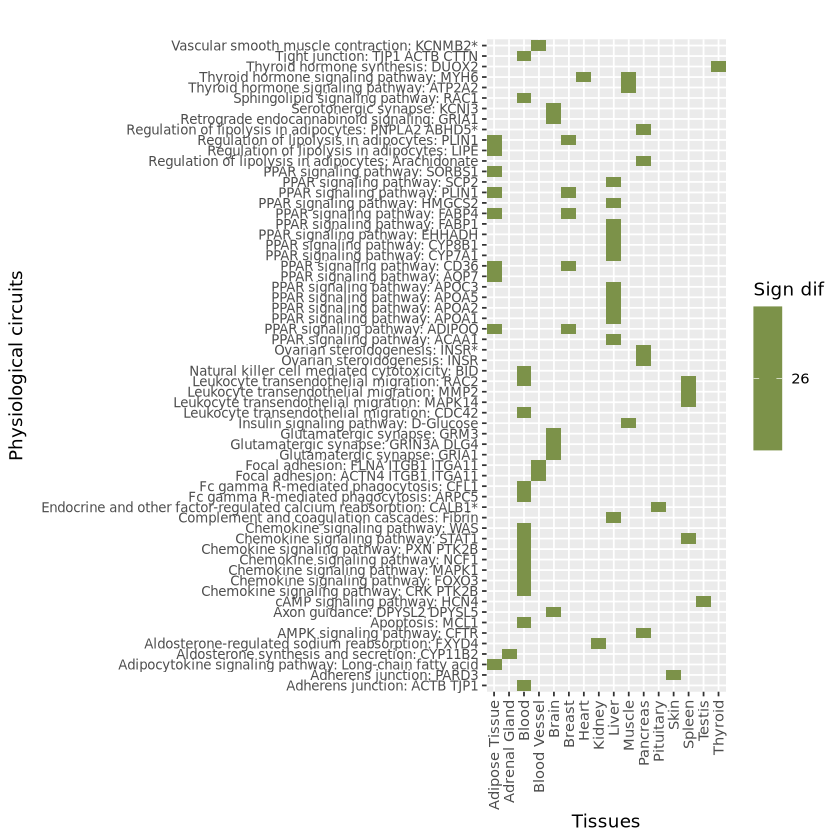

In [16]:
funct_limma_tissues_circ_fq90_logfc <- function(tissue_1,tissue_2){

    if (tissue_1 != tissue_2){
        type <- c(rep(tissue_1, length(annot_comp_fcells[annot_comp_fcells$tissue == tissue_1,"patients"])), rep(tissue_2, length(annot_comp_fcells[annot_comp_fcells$tissue == tissue_2,"patients"])))
        paths <- pathvals_fcells_phys[,c(annot_comp_fcells[annot_comp_fcells$tissue == tissue_1,"patients"],annot_comp_fcells[annot_comp_fcells$tissue == tissue_2,"patients"])]

        design <- model.matrix(~type)
        fit <- lmFit(paths, design)
        fit2 <- eBayes(fit)
        top_table <- topTable(fit2, number = Inf, p.value = 1, adjust="fdr")

        top_table$tissues <- rep(paste(tissue_1, " - ", tissue_2, sep=""), length(rownames(paths)))
        top_table_sign <- top_table[top_table$adj.P.Val < 0.05,]
        top_table_sign_flogfc <- top_table_sign[abs(top_table_sign$logFC) > quantile(abs(top_table_sign$logFC), probs=seq(0,1, by=0.05))[19],]
        top_table_sign_flogfc$circ <- rownames(top_table_sign_flogfc)
        return(rownames(top_table_sign_flogfc))
    }
}   

top_table_limma_tissue_fq90_logfc <- lapply(tissues, FUN=function(y) lapply(tissues, FUN=function(x) funct_limma_tissues_circ_fq90_logfc(x, y)))    

tis_1 <- unlist(lapply(1:length(tissues), FUN=function(x) rep(tissues[x], length(unlist(top_table_limma_tissue_fq90_logfc[x])))))
tis_2 <- unlist(lapply(1:length(tissues), FUN=function(x)  lapply(1:length(tissues), FUN=function(y) rep(tissues[y], length(unlist(top_table_limma_tissue_fq90_logfc[[x]][y]))))))                       

circ_limma_tis_fc90_logfc <- data.frame(
"tissue_1"=tis_1,
"tissue_2"=tis_2,
"circs"= unlist(top_table_limma_tissue_fq90_logfc)
      )  

circ_limma_tis_fc90_logfc %>% group_by(circs, tissue_1) %>% summarise(n=n()) %>% 
filter(n > 25) %>% 
ggplot(aes(x= tissue_1, y = circs, fill = n)) +
  geom_tile() + scale_fill_gradient(low = "#CCFF99",
    high = "#333300",
    na.value = "grey80") +
  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=8)) + scale_y_discrete(name="Physiological circuits") + ggtitle("") + labs(fill="Sign dif")                                                                                                                                                     

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing in

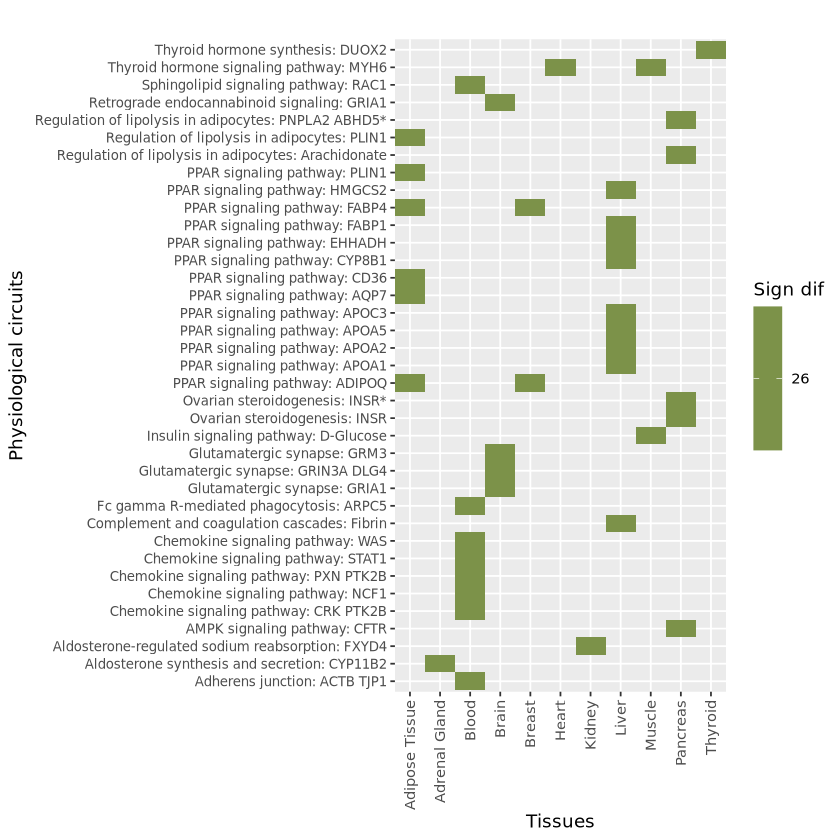

In [17]:
funct_limma_tissues_circ_fq95_logfc <- function(tissue_1,tissue_2){

    if (tissue_1 != tissue_2){
        type <- c(rep(tissue_1, length(annot_comp_fcells[annot_comp_fcells$tissue == tissue_1,"patients"])), rep(tissue_2, length(annot_comp_fcells[annot_comp_fcells$tissue == tissue_2,"patients"])))
        paths <- pathvals_fcells_phys[,c(annot_comp_fcells[annot_comp_fcells$tissue == tissue_1,"patients"],annot_comp_fcells[annot_comp_fcells$tissue == tissue_2,"patients"])]

        design <- model.matrix(~type)
        fit <- lmFit(paths, design)
        fit2 <- eBayes(fit)
        top_table <- topTable(fit2, number = Inf, p.value = 1, adjust="fdr")

        top_table$tissues <- rep(paste(tissue_1, " - ", tissue_2, sep=""), length(rownames(paths)))
        top_table_sign <- top_table[top_table$adj.P.Val < 0.05,]
        top_table_sign_flogfc <- top_table_sign[abs(top_table_sign$logFC) > quantile(abs(top_table_sign$logFC), probs=seq(0,1, by=0.05))[20],]
        top_table_sign_flogfc$circ <- rownames(top_table_sign_flogfc)
        return(rownames(top_table_sign_flogfc))
    }
}   

top_table_limma_tissue_fq95_logfc <- lapply(tissues, FUN=function(y) lapply(tissues, FUN=function(x) funct_limma_tissues_circ_fq95_logfc(x, y)))    

tis_1 <- unlist(lapply(1:length(tissues), FUN=function(x) rep(tissues[x], length(unlist(top_table_limma_tissue_fq95_logfc[x])))))
tis_2 <- unlist(lapply(1:length(tissues), FUN=function(x)  lapply(1:length(tissues), FUN=function(y) rep(tissues[y], length(unlist(top_table_limma_tissue_fq95_logfc[[x]][y]))))))                       

circ_limma_tis_fc95_logfc <- data.frame(
"tissue_1"=tis_1,
"tissue_2"=tis_2,
"circs"= unlist(top_table_limma_tissue_fq95_logfc)
      )          

circ_limma_tis_fc95_logfc %>% group_by(circs, tissue_1) %>% summarise(n=n()) %>% 
filter(n > 25) %>% 
ggplot(aes(x= tissue_1, y = circs, fill = n)) +
  geom_tile() + scale_fill_gradient(low = "#CCFF99",
    high = "#333300",
    na.value = "grey80") +
  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=8)) + scale_y_discrete(name="Physiological circuits") + ggtitle("") + labs(fill="Sign dif")                                                                                                                                                                                                                           

In [18]:
funct_limma_tissues_circ_fq98_logfc <- function(tissue_1,tissue_2){

    if (tissue_1 != tissue_2){
        type <- c(rep(tissue_1, length(annot_comp_fcells[annot_comp_fcells$tissue == tissue_1,"patients"])), rep(tissue_2, length(annot_comp_fcells[annot_comp_fcells$tissue == tissue_2,"patients"])))
        paths <- pathvals_fcells_phys[,c(annot_comp_fcells[annot_comp_fcells$tissue == tissue_1,"patients"],annot_comp_fcells[annot_comp_fcells$tissue == tissue_2,"patients"])]

        design <- model.matrix(~type)
        fit <- lmFit(paths, design)
        fit2 <- eBayes(fit)
        top_table <- topTable(fit2, number = Inf, p.value = 1, adjust="fdr")

        top_table$tissues <- rep(paste(tissue_1, " - ", tissue_2, sep=""), length(rownames(paths)))
        top_table_sign <- top_table[top_table$adj.P.Val < 0.05,]
        top_table_sign_flogfc <- top_table_sign[abs(top_table_sign$logFC) > quantile(abs(top_table_sign$logFC), probs=seq(0,1, by=0.02))[50],]
        top_table_sign_flogfc$circ <- rownames(top_table_sign_flogfc)
        return(rownames(top_table_sign_flogfc))
    }
}   

top_table_limma_tissue_fq98_logfc <- lapply(tissues, FUN=function(y) lapply(tissues, FUN=function(x) funct_limma_tissues_circ_fq98_logfc(x, y)))    

tis_1 <- unlist(lapply(1:length(tissues), FUN=function(x) rep(tissues[x], length(unlist(top_table_limma_tissue_fq98_logfc[x])))))
tis_2 <- unlist(lapply(1:length(tissues), FUN=function(x)  lapply(1:length(tissues), FUN=function(y) rep(tissues[y], length(unlist(top_table_limma_tissue_fq98_logfc[[x]][y]))))))                       

circ_limma_tis_fc98_logfc <- data.frame(
"tissue_1"=tis_1,
"tissue_2"=tis_2,
"circs"= unlist(top_table_limma_tissue_fq98_logfc)
      )        

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing in

`summarise()` has grouped output by 'circs'. You can override using the
`.groups` argument.


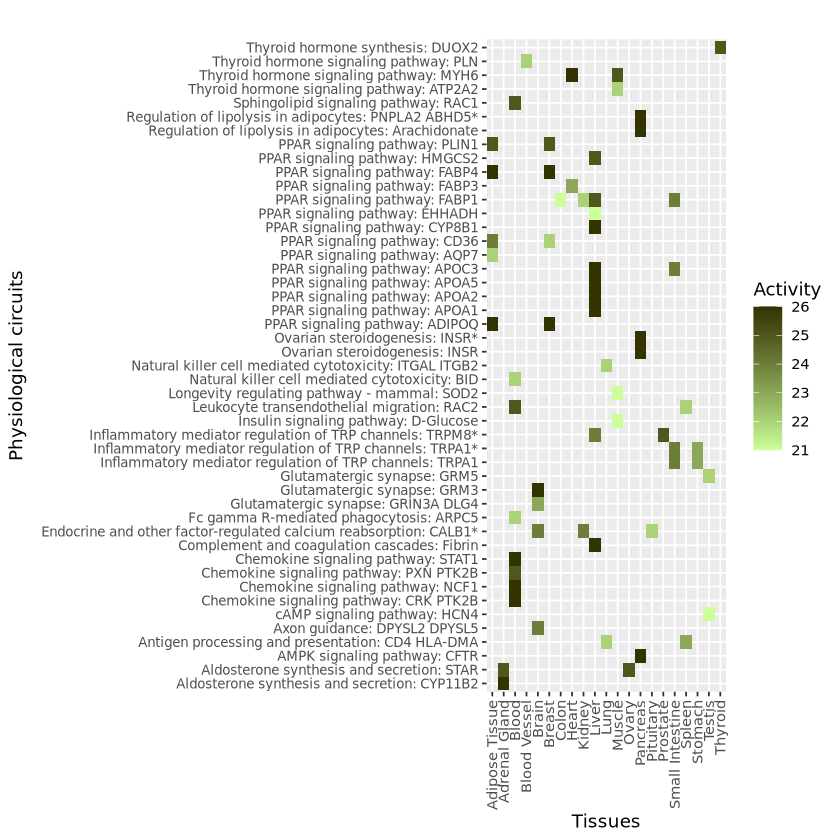

In [19]:
circ_limma_tis_fc98_logfc %>% group_by(circs, tissue_1) %>% summarise(n=n()) %>% 
filter(n > 20) %>% ggplot(aes(x= tissue_1, y = circs, fill = n)) +
  geom_tile() + scale_fill_gradient(low = "#CCFF99",
    high = "#333300",
    na.value = "grey80") +
  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=8)) + scale_y_discrete(name="Physiological circuits") + ggtitle("") + labs(fill="Activity")                                                                                                                                                                                                                           

Using circ as id variables

Using circ as id variables



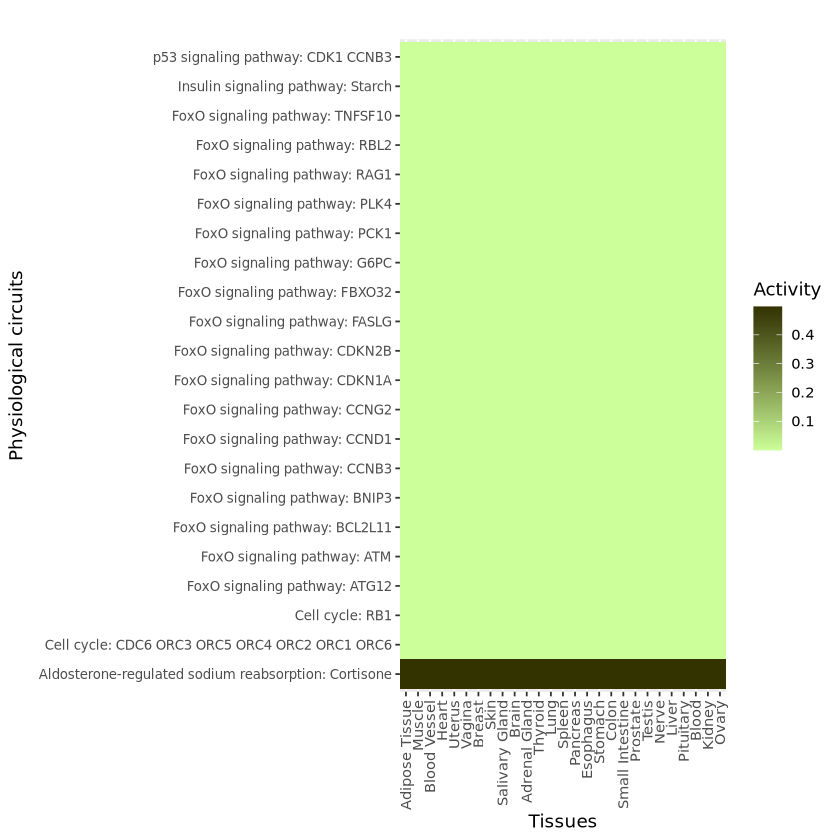

In [20]:
pathvals_mean$circ <- NULL
v_var <- apply(pathvals_mean, 1, var)
df_var <- data.frame(v_var)

circs_mean_var98 <- rownames(df_var)[df_var$v_var > quantile(df_var$v_var, probs=seq(0,1, by=0.01))[99]]

pathvals_mean_var_q98 <- pathvals_mean[circs_mean_var98,]
pathvals_mean_var_q98$circ <- circs_mean_var98
pathvals_mean_var_q98_melt <- melt(pathvals_mean_var_q98)
pathvals_mean_var_q98$circ <- NULL



pathways_menor_var_p2 <- rownames(df_var)[df_var$v_var < quantile(df_var$v_var, probs=seq(0,1, by=0.01))[3]]
pathvals_mean_var_q2 <- pathvals_mean[pathways_menor_var_p2,]
pathvals_mean_var_q2$circ <- pathways_menor_var_p2
pathvals_mean_var_q2_melt <- melt(pathvals_mean_var_q2)
pathvals_mean_var_q2$circ <- NULL

pathvals_mean_var_q2_melt %>% ggplot(aes(x= variable, y = circ, fill = value)) +
  geom_tile() + scale_fill_gradient(low = "#CCFF99",
    high = "#333300",
    na.value = "grey80") +
  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=8)) + scale_y_discrete(name="Physiological circuits") + ggtitle("") + labs(fill="Activity")  

In [21]:
jpeg("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/02_comparation_between_tissues/heatmap_comparation_between_tissues.jpeg", quality = 100, width = 600, height = 400)
pathvals_mean_var_q98_melt %>% ggplot(aes(x= variable, y = circ, fill = value)) +
  geom_tile() + scale_fill_gradient(low = "#CCFF99",
    high = "#333300",
    na.value = "grey80") +
  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=8)) + scale_y_discrete(name="Physiological circuits") + ggtitle("") + labs(fill="Activity")                                                                             
dev.off()

png 
  2

In [41]:
jpeg("/mnt/lustre/scratch/CBRA/research/projects/heterogeneity_mm/results/02_comparation_between_tissues/heatmap_comparation_between_tissues.jpeg", quality = 100, width = 800, height = 600)

pathvals_mean_var_q98_melt %>% ggplot(aes(x= variable, y = circ, fill = value)) +
  geom_tile(color = "gray",
            lwd = 0.5,
            linetype = 1) + scale_fill_gradient(low = "#FAD9CE",
    high = "#D16103",
    na.value = "grey80") +
  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=12), axis.text.x=element_text(size=10)) + 
scale_y_discrete(name="Physiological circuits") + ggtitle("") + labs(fill="Activity")    
dev.off()

png 
  2

In [14]:
length(unique(pathvals_mean_var_q98_melt$variable))

[1] 27

In [15]:
sum_mean_pathvals <- apply(pathvals_mean,1,sum)

In [16]:
sum_mean_pathvals <- apply(pathvals_mean,1,sum)

sum_mean_paths <- lapply(physiological_paths$V1, FUN=function(x) sum(sum_mean_pathvals[grep(x,names(sum_mean_pathvals))]))
sum_pathvals_tissue <- do.call(rbind, lapply(physiological_paths$V1, FUN=function(x) unlist(apply(pathvals_mean[grep(x, rownames(pathvals_mean)),],2,sum))))
rownames(sum_pathvals_tissue) <- physiological_paths$V1

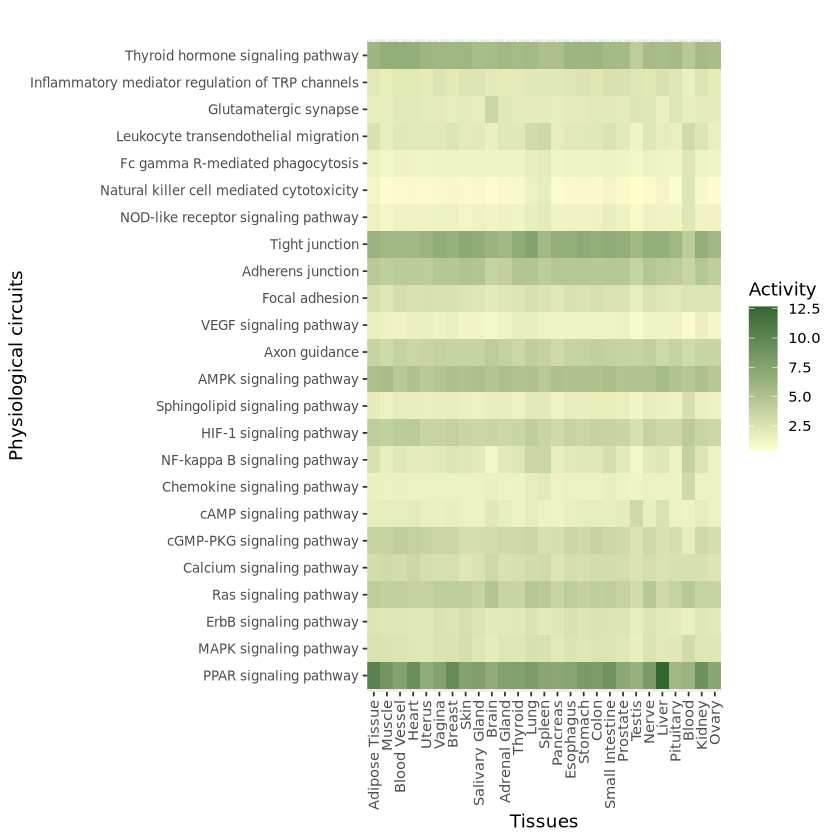

In [17]:
v_var <- apply(sum_pathvals_tissue, 1, var)
df_var <- data.frame(v_var)
path_sum_mean_var70 <- rownames(df_var)[df_var$v_var > quantile(df_var$v_var, probs=seq(0,1, by=0.01))[71]]
melt(sum_pathvals_tissue[path_sum_mean_var70,]) %>% 
ggplot(aes(x= Var2, y = Var1, fill = value)) +
  geom_tile() + scale_fill_gradient(low = "#FFFFCC",
    high = "#336633",
    na.value = "grey80") +
  scale_x_discrete(name="Tissues",expand = expansion(mult = c(0,0)), guide = guide_axis(angle = 90)) + theme(axis.text.y= element_text(size=8)) + scale_y_discrete(name="Physiological circuits") + ggtitle("") + labs(fill="Activity")                                                                             